<a href="https://colab.research.google.com/github/SanBartolome/IA-diploma-course-2021/blob/main/Desafio4_Monedas_San_Bartolom%C3%A9_Carlos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial - Inteligencia Artificial para Juegos (Game IA) - Sesión 4 - Tarea - Parte 2

<img src='https://escuela.pucp.edu.pe/gobierno/wp-content/uploads/2015/04/logo-pucp-full-color-300x88.png' width=200px>


Dr. Edwin Villanueva, Ing. Daniel Saromo

04/12/2021

<font color='orange'>Entorno de las torres de monedas.</font>

El presente notebook aborda el problema de busqueda adversarial en el juego de **las torres de monedas**. 

El juego se define de la siguiente manera:

- Inicialmente, se tiene un número impar de monedas en una torre.

- Cada jugador divide una de las torres en dos grupos con cantidad desigual de monedas.

- El juego termina cuando cada una de las torres tiene una o dos monedas.

- Pierde el primer jugador que ya no puede realizar ninguna movida.

- El estado del tablero se representa como una lista, cuyos elementos representan la cantidad de monedas presentes en cada una de las torres el tablero.

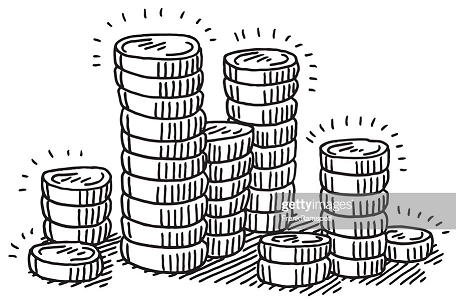



El entorno del juego está completamente implementado, así como los algoritmos MINIMAX, ALPHA-BETA, y Monte Carlo Tree Search que pueden ser llamados como jugadores. 

Recordar que en el algoritmo `minimax`, los valores altos de utilidad son buenos para el jugador MAX.

Considerar que las fichas del jugador MAX son **X**, mientas que las fichas del jugador MIN son **O**.

Completar con su código los campos requeridos y subir su notebook solucionado a la plataforma PAIDEIA. El formato del nombre del notebook es: `Desafio4_Monedas_APELLIDOPATERNO_NOMBRE.ipynb`.

Es responsabilidad del alumno verificar que el archivo que subió es el correcto. Respetar los lineamientos de la entrega de archivo, ya que influirá en su calificación. La fecha límite de entrega del presente desafío se encuentra en PAIDEIA.

### Clase <b>Game</b>

Esta es una clase genérica para definir un entorno de juego. Es parecida a la clase `Problem` de búsqueda, pero en vez del método que devuelve el costo de camino se tiene un metodo que devuelve la utilidad de un jugador en un estado dado. También la funcion test de objetivo es reemplazada por un test de estado terminal (`terminal_test`). Para crear una clase de un juego específico se debe hacer una subclase de `Game` e implementar los métodos actions, `result`, `utility`, y `terminal_test`. El atributo `.initial` (estado inicial del juego) deberá ser inicializado en el constructor de la clase concreta. No editar esta clase `Game`.

In [ ]:
class Game:

    def actions(self, state):
        """Retorna una lista de movidas permitidas en el estado actual state."""
        raise NotImplementedError

    def result(self, state, move):
        """Retorna el nuevo estado que resulta de hacer una movida move en el estado state."""
        raise NotImplementedError

    def utility(self, state, player):
        """Retorna el valor de utilidad para el jugador player en el estado terminal state."""
        raise NotImplementedError

    def terminal_test(self, state):
        """Retorna True si el estado state es un estado terminal del juego."""
        return not self.actions(state)

    def to_move(self, state):
        """Retorna el jugador que le toca jugar en el presente estado state."""
        return state.to_move

    def display(self, state):
        """Imprime o displaya el state."""
        print(state)

    def __repr__(self):
        return '<{}>'.format(self.__class__.__name__)

    def play_game(self, *players, verbose):
        """Controlador del juego:
        Llama alternadamente a cada jugador pasandole el estado actual del juego y ejecutando la movida retornada."""
        state = self.initial
        numJugada = 0
        while True:
            for player in players:
                move = player(self, state)
                mark_now = self.to_move(state)
                state = self.result(state, move)
                numJugada = numJugada + 1
                if verbose:
                  print("Jugada", numJugada, ": Turno del jugador", player.__name__, "(",mark_now,")")
                  print("Movimiento realizado:", move)
                  self.display(state)
                  print("*************************************************")
                if self.terminal_test(state):
                    print("Jugada", numJugada, "(final): Turno del jugador", player.__name__, "(",mark_now,")")
                    self.display(state)
                    print("La utilidad del primer jugador (",self.to_move(self.initial),") fue: ")
                    #retorna utilidad del 1er jugador al acabar el juego
                    return self.utility(state, self.to_move(self.initial))

### Clase <b>Monedas</b>

Esta es una subclase de `Game` para definir el entorno del juego de las torres de las monedas. Primer jugador (Max) es 'X' y el otro jugador (Min) es 'O'. Un estado en este juego es una tupla (`GameState`) con los siguientes campos:
 - to_move: almacena el jugador que le toca jugar 
 - utility: almacena la utilidad del estado
 - board: almacena las torres de monedas en el tablero en la forma de una lista, donde cada uno de sus elementos representa la cantidad de monedas por cada torre.
 - moves: almacena las movidas posibles a partir del estado en la forma de una lista de listas que representan posibles configuraciones del tablero. 

In [ ]:
from collections import namedtuple
import random
import itertools
import copy

#Para este entorno, un estado es una tupla con nombres de campos (namedtuple)
GameState = namedtuple('GameState', 'to_move, utility, board, moves')

class Monedas(Game):
    
    def __init__(self, torres_inicial = [7]):

        self.torres_inicial = torres_inicial

        #board = [[1,1], [1,1]]
        board = self.torres_inicial

        moves = self.generaSucesores(board)
        
        self.initial = GameState(to_move='X', utility=0, board=board, moves=moves)

    def areElementsOfLista1InsideLista2(self, lista1, lista2):
        elementsOfLista1AreInsideLista2=True

        for j in lista1:
            if j not in lista2:
                elementsOfLista1AreInsideLista2 = False
                break

        return elementsOfLista1AreInsideLista2

    def generaSucesores(self,listaInicial):
        #lista = listaInicial.copy()
        listaDeListas = []
        for i in listaInicial:
            umbral = int(i/2)
            for j in range(i-1,umbral,-1):
                nuevaLista = listaInicial.copy()
                nuevaLista.remove(i)#eliminamos al elemento de la lista, para que solamente queden sus hijos
                hijo_1 = j
                hijo_2 = i-j

                nuevaLista = [hijo_1, hijo_2] + nuevaLista
                nuevaListaEstaEnListaDeListas = False

                for lista in listaDeListas:
                    
                    if self.areElementsOfLista1InsideLista2(nuevaLista, lista):
                        nuevaListaEstaEnListaDeListas = True

                #si la nuevaLista no está en listaDeListas, entonces la agrego a listaDeListas
                if not (nuevaListaEstaEnListaDeListas):
                    listaDeListas.append(nuevaLista)

        return listaDeListas

    def actions(self, state):
        """Movidas legales son todos las posibles distribuciones válidas de las monedas en torres (el estado almacena las movidas legales)"""
        board = state.board.copy()
        moves = self.generaSucesores(board)

        return moves

    def result(self, state, move):
        """Retorna el nuevo estado, resultante de hacer la movida move en el estado state."""

        board = move.copy()
        moves = self.actions(state)

        return GameState(to_move=('O' if state.to_move == 'X' else 'X'),
                         utility=self.compute_utility(board, state.to_move),
                         board=board, moves=moves)

    def utility(self, state, player):
        """Retorna la utilidad del player en estado terminal state; 1 si ganó, -1 si perdió, 0 empate."""
        return state.utility if player == 'X' else -state.utility

    def terminal_test(self, state):
        """Un estado es terminal si hay un ganador o no hay mas movidas posibles."""
        return state.utility != 0 or len(state.moves) == 0

    def display(self, state):
        print("Estado del tablero con las torres de monedas:")
        print(state.board)

    def compute_utility(self, board, player):
        """Retorna  1 si player='X'  ha llegado a estado terminal ganador, 
           Retorna -1 si player='O' ha llegado a estado terminal ganador,
           Retornas 0 en cualquier otro caso"""

        siguienteEstado = self.generaSucesores(board)

        win = (len(siguienteEstado) == 0)

        return 0 if not win else +1 if player == 'X' else -1


### Algoritmo  <b>MIN-MAX</b>

Este algoritmo escoge una movida para el jugador de turno en un juego dado (game). El algoritmo obtiene recursivamente los valores minimax de los estados sucesores buscando en profundidad en el arbol de juego los estados terminales. De estos estados toma su valor de utilidad para calcular la utilidad de los padres y asi sucesivamente hasta tener la utilidad de todos los sucesores del estado inicial para decidir la movida a ejecutar. 
La implementacion de esta busqueda es a traves de una recursion alternada de las funciones max_value y min_value (una llama a la otra) hasta alcanzar un estado terminal. Cuando la recursion termina todas las movidas tienen una utilidad y se escoje la movida de mayor valor.


In [ ]:
argmax = max
infinity = float('inf')

def minimax_decision(state, game):

    player = game.to_move(state)

    def max_value(state):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = -infinity
        for a in game.actions(state):
            v = max(v, min_value(game.result(state, a)))
        return v

    def min_value(state):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = infinity
        for a in game.actions(state):
            v = min(v, max_value(game.result(state, a)))
        return v

    # Body of minimax_decision:
    #Cuando la recursion termina todas las movidas tienen una
    #utilidad y se escoje la movida de mayor valor.
    return argmax(game.actions(state),
                  key=lambda a: min_value(game.result(state, a)))

### Algoritmo  <b>ALPHA-BETA</b>

Este algoritmo escoge una movida para el jugador de turno en el juego, evitando explorar las ramas que no son relevantes para tomar una decisión de movida en el estado actual. Alpha-Beta hace uso de las funciones max_value y min_value de MIN-MAX pero utilizando dos variables: alpha y betha. La variable apha mantiene la mejor opcion (la más alta utilidad) encontrada para MAX a lo largo del camino. La variable betha mantiene la mejor opcion (la más baja utilidad) encontrada para MIN. A medida que el algoritmo avanza se va actualizando alpha y betha y se poda un nodo cuando el valor del nodo es menor que el valor alpha (para MAX) o mayor que el valor betha (para MIN).

In [ ]:
def alphabeta_search(state, game):
  
    player = game.to_move(state)

    # Functions used by alphabeta
    def max_value(state, alpha, beta):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = -infinity
        for a in game.actions(state):
            v = max(v, min_value(game.result(state, a), alpha, beta))
            if v >= beta:
                return v
            alpha = max(alpha, v)
        return v

    def min_value(state, alpha, beta):
        if game.terminal_test(state):
            return game.utility(state, player)
        v = infinity
        for a in game.actions(state):
            v = min(v, max_value(game.result(state, a), alpha, beta))
            if v <= alpha:
                return v
            beta = min(beta, v)
        return v

    # Body of alphabeta_search:
    best_score = -infinity
    beta = infinity
    best_action = None
    for a in game.actions(state):
        v = min_value(game.result(state, a), best_score, beta)
        if v > best_score:
            best_score = v
            best_action = a
    return best_action

### Algoritmo  <b>Monte-Carlo Tree Search (MCTS)</b>


#### Implementa el nodo del arbol Monte carlo 

In [ ]:
class MCT_Node:
    """Nodo del árbol de búsqueda Monte Carlo. Hace un seguimiento de los estados hijos (`children` states)."""

    def __init__(self, parent=None, state=None, U=0, N=0):
        self.__dict__.update(parent=parent, state=state, U=U, N=N)
        self.children = {}
        self.actions = None

#### Implementa la funcion UCB1 para la fase de selección

In [ ]:
import numpy as np

def ucb(n, C=1.4):
    """Función UCB para la fase de selección."""
    if n.N == 0:
        return np.inf    
    else:
        return (n.U / n.N) + C * np.sqrt(np.log(n.parent.N) / n.N)

#### Algoritmo Monte-Carlo Tree Search

In [ ]:
import random
def monte_carlo_tree_search(state, game, N=1000):
    def select(n):
        """Selecciona un leaf node en el árbol."""
        if n.children:
            return select(max(n.children.keys(), key=ucb))
        else:
            return n

    def expand(n):
        """Expande el leaf node agregando todos sus estados hijo (`children` states)."""
        if not n.children and not game.terminal_test(n.state):
            n.children = {MCT_Node(state=game.result(n.state, action), parent=n): action
                          for action in game.actions(n.state)}
        return select(n)

    def simulate(game, state):
        """Simula la utilidad del estado actual al tomar aleatoriamente un paso."""
        player = game.to_move(state)
        while not game.terminal_test(state):
            action = random.choice(list(game.actions(state)))
            state = game.result(state, action)
        v = game.utility(state, player)
        return -v

    def backprop(n, utility):
        """Pasa la utilidad a todos los nodos padre (es decir, hacia atrás)."""
        if utility > 0:
            n.U += utility
        # if utility == 0:
        #     n.U += 0.5
        n.N += 1
        if n.parent:
            backprop(n.parent, -utility)

    root = MCT_Node(state=state)

    for _ in range(N):
        leaf = select(root)
        child = expand(leaf)
        result = simulate(game, child.state)
        backprop(child, result)

    max_state = max(root.children, key=lambda p: p.N)

    return root.children.get(max_state)

### Jugadores </b>

A seguir se implementan 4 agentes jugadores que pueden hacer movidas en un entorno de juego, dado su estado :
- <b>minimax_player</b>:   jugador que hace movidas de acuerdo al algoritmo MIN-MAX
- <b>alphabeta_player</b>: jugador que hace movidas de acuerdo al algoritmo ALPHA-BETA
- <b>mcts_player</b>:    jugador que hace movidas de acuerdo al algoritmo MCTS
- <b>random_player</b>:    jugador que hace movidas aleatorias (es facil ganarle :v )
- <b>human_player</b>:     solicita la movida a un humano


In [ ]:
def minimax_player(game, state):
    return minimax_decision(state, game)

def alphabeta_player(game, state):
    return alphabeta_search(state, game)

def mcts_player(game, state):
    return monte_carlo_tree_search(state, game)

def random_player(game, state):
    return random.choice(game.actions(state))

def human_player(game, state):
    #print("Estado actual:")
    game.display(state)
    print("Movidas disponibles: {}".format(game.actions(state)))
    print("")

    entrada = input('Cuál es tu movida?\n'
                                    'Ejemplo de sintaxis de entrada: [2,1]\n')
    try:
        move = eval(entrada)
    except NameError:
        move = entrada
    return move

### Jugando

In [ ]:
ttt = Monedas([5,3])
print(ttt.play_game(random_player, human_player, verbose=True))

Jugada 1 : Turno del jugador random_player ( X )
Movimiento realizado: [2, 1, 5]
Estado del tablero con las torres de monedas:
[2, 1, 5]
*************************************************
Estado del tablero con las torres de monedas:
[2, 1, 5]
Movidas disponibles: [[4, 1, 2, 1], [3, 2, 2, 1]]

Cuál es tu movida?
Ejemplo de sintaxis de entrada: [2,1]
[3, 2, 2, 1]
Jugada 2 : Turno del jugador human_player ( O )
Movimiento realizado: [3, 2, 2, 1]
Estado del tablero con las torres de monedas:
[3, 2, 2, 1]
*************************************************
Jugada 3 : Turno del jugador random_player ( X )
Movimiento realizado: [2, 1, 2, 2, 1]
Estado del tablero con las torres de monedas:
[2, 1, 2, 2, 1]
*************************************************
Jugada 3 (final): Turno del jugador random_player ( X )
Estado del tablero con las torres de monedas:
[2, 1, 2, 2, 1]
La utilidad del primer jugador ( X ) fue: 
1


In [ ]:
ttt = Monedas([5])
print(ttt.play_game(human_player, human_player, verbose=True))

In [ ]:
ttt = Monedas([5])
print(ttt.play_game(random_player, random_player, verbose=True))

In [ ]:
ttt = Monedas([7])
print(ttt.play_game(minimax_player, mcts_player, verbose=True))

In [ ]:
ttt = Monedas([9,3])
print(ttt.play_game(alphabeta_player, alphabeta_player, verbose=True))

## Desafío de la semana: Entorno `Monedas`  <font color=red> (1 punto en total) </font>

- No olvidar resolver la otra parte del desafío de la semana (Entorno `ConnectFour`).


- Se les pide elaborar el árbol de juego del entorno de las torres de monedas, para el estado inicial `[7,1]` <font color=red> (0.5 puntos) </font>.



- Además, se pide colocar el valor de utilidad para cada uno de los estados, y elegir las acciones que realizaría el primer jugador si se considera que sus acciones se basan en la aplicación del algoritmo MINIMAX <font color=red> (0.5 puntos) </font>.



- Para comprobar experimentalmente dichas acciones generadas por el algoritmo MINIMAX ante un agente aleatorio, instanciar el entorno de esta manera: `Monedas([7,1])`.

In [ ]:
ttt = Monedas([7,1])
print(ttt.play_game(minimax_player, random_player, verbose=True))



- Guiarse de la figura de ejemplo.

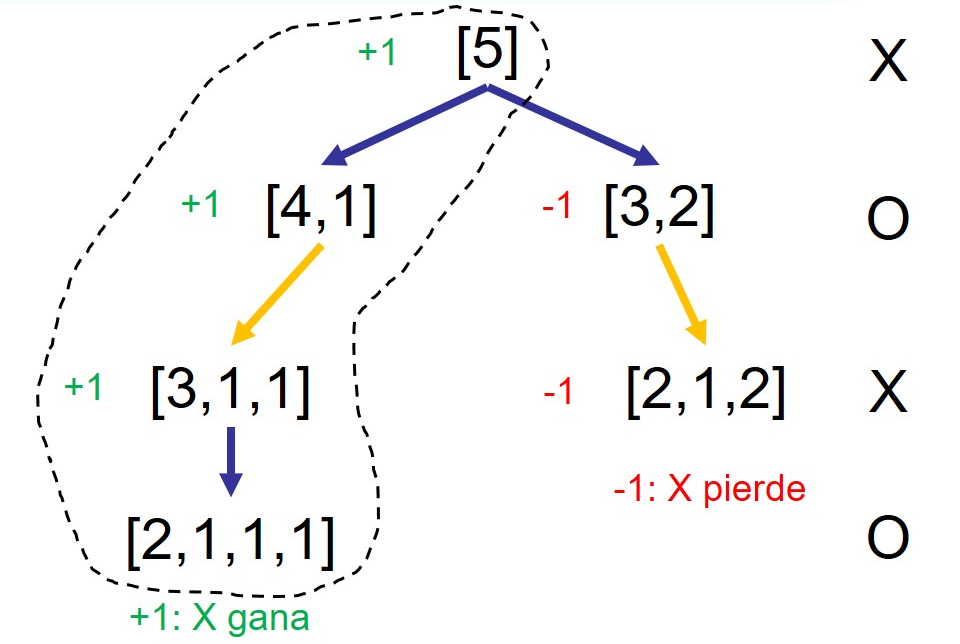



- Si están trabajando en Jupyter, y no se puede incrustar la imagen en el notebook ipynb, tiene que adjuntar su imagen en su archivo de entrega. Dicho fichero sería ahora un comprimido con extensión `.rar`.

El puntaje total correspondiente al presente desafío es de 1 punto.

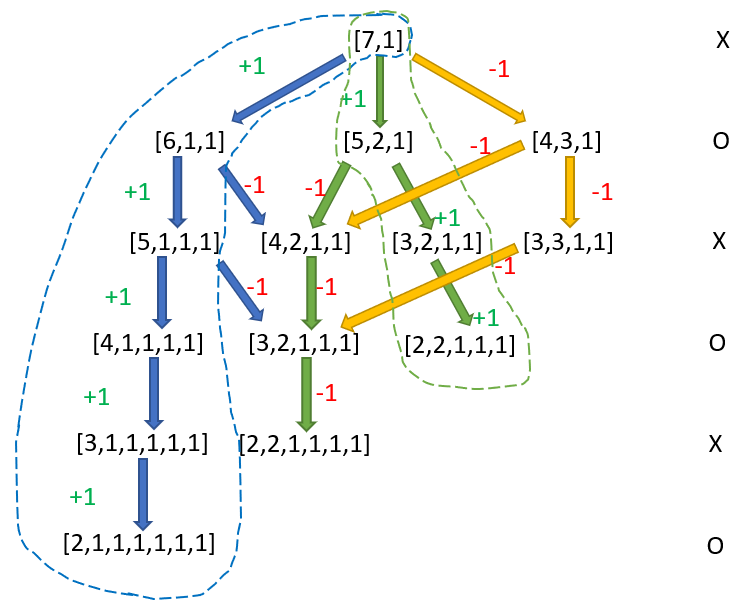